---
# <font color="DarkBlue"><b><center>Escuela Politécnica Nacional</center></b></font>
---

## <font color="DarkGreen"><center>Ransomware dynamics: Mitigating personal data exfiltration through the SCIRAS lens</font>

## <font color="DarkGreen"><center>Traditional machine learning algorithms</font>

**Author:** David Cevallos-Salas, José Estrada-Jiménez, Danny S. Guamán, Luis Felipe Urquiza

**Date:** 2025-03-17

**Google Colab Link:**
https://colab.research.google.com/drive/1E-7_Nfq6qpxA4ZzNvkYF_RlUOhlGy1nM?authuser=1

In [1]:
# Importing libraries
from os import X_OK
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras.utils import to_categorical,plot_model
from sklearn.pipeline import Pipeline as skPipeline
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, train_test_split
import sklearn.metrics as mt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
import imblearn.metrics as imt
import zipfile
import os

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
!git clone https://github.com/dcevallossalas/ransmap1

node = "dataset"
y = np.array([])
first = True
first1 = True

families = os.listdir("/content/ransmap1/" + node + "/")

for family in families:
  annotations = os.listdir("/content/ransmap1/" + node + "/" + family)
  for annotation in annotations:
    files =  os.listdir("/content/ransmap1/" + node + "/" + family + "/" + annotation)
    for file in files:
      zipped = False
      if file.endswith(".zip") and file.startswith("mem_write"):
        zipped = True
        path1 = "/content/ransmap1/" + node + "/" + family + "/" + annotation + "/" + file
        path2 = "/home"
        with zipfile.ZipFile(path1, 'r') as zip_ref:
          zip_ref.extractall(path2)

        file = file.replace(".zip",".csv")

      if file.endswith("mem_write.csv"):
        if zipped:
          data = pd.read_csv(path2 + "/original/dataset/"+ family + "/" + annotation+"/" + file)
        else:
          data = pd.read_csv("/content/ransmap1/" + node + "/" + family + "/" + annotation+"/" + file)

        x1 = data

        if first:
          x = x1
          first = False
        else:
          x = np.concatenate((x,x1))

        n = len(x1)

        if annotation.startswith("LockBit"):
          code = 1
        elif annotation.startswith("Ryuk"):
          code = 2
        elif annotation.startswith("Conti"):
          code = 3
        elif annotation.startswith("REvil"):
          code = 4
        elif annotation.startswith("Darkside"):
          code = 5
        elif annotation.startswith("WannaCry"):
          code = 6
        else:
          code = 0

        if first1:
          y = np.full(n,code)
          first1 = False
        else:
          y = np.concatenate((y,np.full(n,code)))

# Number of metrics
num_metrics = 8

# Number of classes
num_classes = 7

# Definition of labels
labels = [
    "Benign",
    "LockBit",
    "Ryuk",
    "Conti",
    "Sodinokibi",
    "Darkside",
    "WannaCry"
]

Cloning into 'ransmap1'...
remote: Enumerating objects: 264, done.
remote: Total 264 (delta 0), reused 0 (delta 0), pack-reused 264 (from 1)
Receiving objects: 100% (264/264), 375.25 MiB | 19.14 MiB/s, done.
Resolving deltas: 100% (120/120), done.
Updating files: 100% (120/120), done.


In [3]:
# Representative random stratified sample
x, x1, y, y1 = train_test_split(x, y, train_size=0.01, shuffle=True, random_state = 1234, stratify=y)

# Splitting (training and test balanced sets definitions)
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, shuffle=True, random_state = 1234, stratify = y)

# Number of samples per category
print("Benign: " + str(np.sum(y==0)))
print("LockBit: " + str(np.sum(y==1)))
print("Ryuk: " + str(np.sum(y==2)))
print("Conti: " + str(np.sum(y==3)))
print("Sodinokibi: " + str(np.sum(y==4)))
print("Darkside: " + str(np.sum(y==5)))
print("WannaCry: " + str(np.sum(y==6)))

Benign: 154761
LockBit: 82740
Ryuk: 28486
Conti: 77268
Sodinokibi: 80307
Darkside: 60706
WannaCry: 63228


In [4]:
def visualizeResults(x_test, y_test, pipeline):
  # Test evaluation
  y_test_pred_proba = pipeline.predict_proba(x_test)

  y_test_pred = pipeline.predict(x_test)
  f1score = mt.f1_score(y_test, y_test_pred, average="weighted")
  acc = mt.accuracy_score(y_test, y_test_pred)
  preci = mt.precision_score(y_test, y_test_pred, average="weighted")
  recall = mt.recall_score(y_test, y_test_pred, average="weighted")

  # Classification report
  print("Classification report")
  report = mt.classification_report(y_test, y_test_pred)
  print(report)

  # Confusion matrix
  # TN FP
  # FN TP
  # print("Confusion matrix")
  # print(y_test_pred)
  cm = mt.confusion_matrix(y_test, y_test_pred)
  pd_cm = pd.DataFrame(cm,
             columns=labels,
             index=labels)
  # print(pd_cm)

  # Display confusion matrix using ConfusionMatrixDisplay
  # g_cm = mt.ConfusionMatrixDisplay(cm,display_labels=labels).plot()
  # plt.show(g_cm)

  # Display confusion matrix using Heat Map
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, fmt='g', ax=ax,
    square=True,
    cmap="Blues",
    linewidths=0.2,
    annot_kws={"fontsize":5.5})
  ax.set_xlabel("Predicted values", fontsize=8)
  ax.set_ylabel("True values", fontsize=8)
  ax.xaxis.set_ticklabels(labels, fontsize=8)
  ax.yaxis.set_ticklabels(labels, fontsize=8)
  cbar = ax.collections[0].colorbar
  cbar.ax.tick_params(labelsize=8)
  plt.yticks(rotation=0)
  plt.xticks(rotation=90)

  # ROC curves
  import colorcet as cc

  palette = sns.color_palette(cc.glasbey, num_classes)
  palette1 = sns.color_palette(cc.glasbey, 16)
  palette[0] = palette1[10]
  palette[1] = palette1[0]

  t_test_oneh = to_categorical(y_test,num_classes)
  fig, ax = plt.subplots()
  auc = 0

  for i in np.arange(0,num_classes):
    fpr, tpr, thresholds = mt.roc_curve(t_test_oneh[:, i], y_test_pred_proba[:, i])
    auc_value = round(mt.auc(fpr, tpr),4)
    auc = auc+auc_value
    plt.plot(fpr, tpr,color=palette[i],label=labels[i] + " (AUC="+str(auc_value)+")")

  plt.plot([0,1],[0,1],"k--")
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc="best", prop={'size': 6})
  plt.grid()
  plt.show()

  auc = auc/num_classes

  # Test evaluation results
  print("Test evaluation results: recall =", recall, ", F1 =", f1score, ", acc =", acc, ", precision =", preci, "auc =", auc)


In [5]:
# Function for calculating Metrics - Multiclass classifier
def calculateMetrics(ytrue, ypred, yproba, labels, pictures=False):
  if pictures:
    print("Matriz de confusión")
    cm = mt.confusion_matrix(ytrue, ypred)

    # Matrix confusion
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax,
      square=True,
      cmap="Blues",
      linewidths=0.2,
      annot_kws={"fontsize":5.5})
    ax.set_xlabel("Predicted category", fontsize=8)
    ax.set_ylabel("True category", fontsize=8)
    ax.xaxis.set_ticklabels(labels, fontsize=8)
    ax.yaxis.set_ticklabels(labels, fontsize=8)
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=8)
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    plt.show()

  # Calculating metrics
  precision = mt.precision_score(ytrue, ypred, average="micro")
  recall = mt.recall_score(ytrue, ypred, average="micro")
  f1score = mt.f1_score(ytrue, ypred, average="micro")
  accuracy = mt.accuracy_score(ytrue, ypred)
  error = 1-accuracy
  specificity = imt.specificity_score(ytrue, ypred, average="micro")
  fprm = 1-specificity

  # ROC curve
  numClases = len(labels)

  if pictures:
    numClases_color = numClases

    if numClases < numClases:
      numClases_color = numClases

    palette = sns.color_palette(cc.glasbey, numClases_color)
    palette = [palette[10],palette[0]]+palette[1:10]+palette[11:]
    fig, ax = plt.subplots()

  ytrue_oneh = to_categorical(ytrue,num_classes)
  auc=0

  for i in np.arange(0,numClases):
    fpr, tpr, thresholds = mt.roc_curve(ytrue_oneh[:, i], yproba[:, i], drop_intermediate=False)
    auc_value = round(mt.auc(fpr, tpr),4)
    auc = auc + auc_value
    if pictures:
      plt.plot(fpr, tpr, color=palette[i], label=labels[i] + " (AUC="+str(auc_value)+")")

  if pictures:
    plt.plot([0,1], [0,1], "--k")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.legend(loc="lower right", prop={'size': 6})
    plt.grid()
    plt.show()

  auc = auc/numClases

  # Present metrics
  print("------------------------------")
  print("Valores de métricas obtenidas:")
  print("------------------------------")
  print("precision:", precision)
  print("recall:", recall)
  print("f1-score:", f1score)
  print("accuracy:", accuracy)
  print("error:", error)
  print("specificity:", specificity)
  print("false positive rate:", fprm)
  print("auc:", auc)

  return np.array([[precision],[recall],[f1score],[accuracy],[error],[specificity],[fprm],[auc]])

In [6]:
def visualizeResultsGeneral(x_test, y_test, pipeline):
  # Test evaluation
  # y_test_pred_proba = pipeline.predict_proba(x_test)

  y_test_pred = pipeline.predict(x_test)
  f1score = mt.f1_score(y_test, y_test_pred, average="weighted")
  acc = mt.accuracy_score(y_test, y_test_pred)
  preci = mt.precision_score(y_test, y_test_pred, average="weighted")
  recall = mt.recall_score(y_test, y_test_pred, average="weighted")

  # Classification report
  print("Classification report")
  report = mt.classification_report(y_test, y_test_pred)
  print(report)

  # Confusion matrix
  # TN FP
  # FN TP
  # print("Confusion matrix")
  # print(y_test_pred)

  cm = mt.confusion_matrix(y_test, y_test_pred)
  pd_cm = pd.DataFrame(cm,
             columns=labels,
             index=labels)
  # print(pd_cm)

  # Display confusion matrix using ConfusionMatrixDisplay
  # g_cm = mt.ConfusionMatrixDisplay(cm,display_labels=labels).plot()
  # plt.show(g_cm)

  # Display confusion matrix using Heat Map
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, fmt='g', ax=ax,
    square=True,
    cmap="Blues",
    linewidths=0.2,
    annot_kws={"fontsize":5.5})
  ax.set_xlabel("Predicted values", fontsize=8)
  ax.set_ylabel("True values", fontsize=8)
  ax.xaxis.set_ticklabels(labels, fontsize=8)
  ax.yaxis.set_ticklabels(labels, fontsize=8)
  cbar = ax.collections[0].colorbar
  cbar.ax.tick_params(labelsize=8)
  plt.yticks(rotation=0)
  plt.xticks(rotation=90)

  # Test evaluation results
  print("Test evaluation results: recall =", recall, ", F1 =", f1score, ", acc =", acc, ", precision =", preci)

# Decision Tree

In [23]:
# General
np.random.seed(1)

pipeline_nsm = skPipeline([
        ("scaler", StandardScaler()),
        ("clf", tree.DecisionTreeClassifier(random_state=0))])

# Repeated kfold cross validation definition
rkfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=45)

# Parameters of grid
param_grid = {
                "clf__criterion": ["gini","entropy"],
                "clf__max_depth": [3]
              }

# #####################
# GridSearchCV
# #####################
print("------------------------------")
print("Decision tree")
print("------------------------------")
search = GridSearchCV(pipeline_nsm, param_grid, cv=rkfold, scoring='f1_micro', verbose=4)
result = search.fit(x_train, y_train)

# Training with best hyperparameters
pipeline_nsm.set_params(
    clf__criterion = result.best_params_["clf__criterion"],
    clf__max_depth = result.best_params_["clf__max_depth"]
    )

print(f"Best result at validation set: {result.best_score_} with hyperparameters {result.best_params_}")

print("Retraining:")
pipeline_nsm.fit(x_train, y_train)




------------------------------
Decision tree
------------------------------
Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV 1/10] END clf__criterion=gini, clf__max_depth=3;, score=0.697 total time=   0.7s
[CV 2/10] END clf__criterion=gini, clf__max_depth=3;, score=0.697 total time=   0.4s
[CV 3/10] END clf__criterion=gini, clf__max_depth=3;, score=0.697 total time=   0.4s
[CV 4/10] END clf__criterion=gini, clf__max_depth=3;, score=0.696 total time=   0.5s
[CV 5/10] END clf__criterion=gini, clf__max_depth=3;, score=0.697 total time=   0.6s
[CV 6/10] END clf__criterion=gini, clf__max_depth=3;, score=0.697 total time=   0.6s
[CV 7/10] END clf__criterion=gini, clf__max_depth=3;, score=0.696 total time=   0.6s
[CV 8/10] END clf__criterion=gini, clf__max_depth=3;, score=0.697 total time=   0.4s
[CV 9/10] END clf__criterion=gini, clf__max_depth=3;, score=0.696 total time=   0.4s
[CV 10/10] END clf__criterion=gini, clf__max_depth=3;, score=0.697 total time=   0.4s
[CV 1/10] EN

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 DecisionTreeClassifier(criterion='entropy', max_depth=3,
                                        random_state=0))])

Classification report
              precision    recall  f1-score   support

           0       1.00      0.84      0.92     30952
           1       0.84      1.00      0.91     16548
           2       1.00      1.00      1.00      5697
           3       1.00      1.00      1.00     15454
           4       1.00      1.00      1.00     16062
           5       0.88      1.00      0.94     12141
           6       1.00      1.00      1.00     12646

    accuracy                           0.96    109500
   macro avg       0.96      0.98      0.97    109500
weighted avg       0.96      0.96      0.96    109500



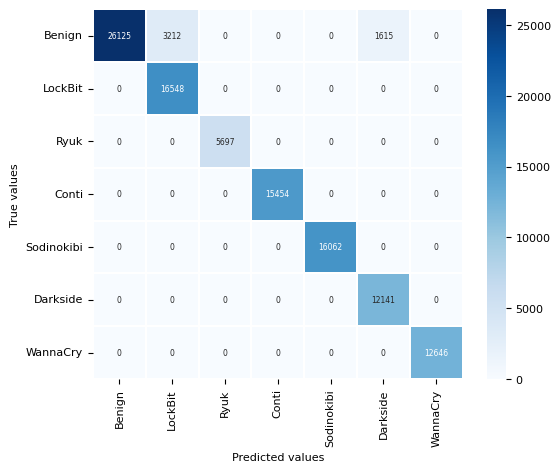

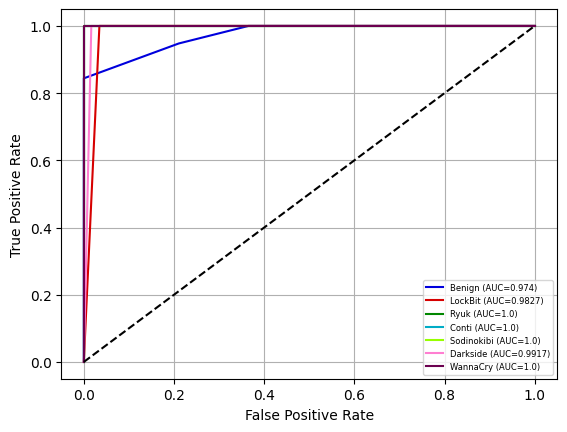

Test evaluation results: recall = 0.855917808219178 , F1 = 0.855811172667794 , acc = 0.855917808219178 , precision = 0.8624175242392552 auc = 0.8926285714285713


In [24]:
visualizeResults(x_test, y_test, pipeline_nsm)

# Random Forest

In [25]:
# General
np.random.seed(1)

pipeline_nsm = skPipeline([
        ("scaler", StandardScaler()),
        ("clf", RandomForestClassifier(random_state=0))])

# Repeated kfold cross validation definition
rkfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=45)

# Parameters of grid
param_grid = {
                "clf__n_estimators": range(5,11,5),
                "clf__criterion": ["gini","entropy"],
                "clf__max_depth": [3,5]
              }

# #####################
# GridSearchCV
# #####################
print("------------------------------")
print("Random Forest")
print("------------------------------")
search = GridSearchCV(pipeline_nsm, param_grid, cv=rkfold, scoring='f1_micro', verbose=4)
result = search.fit(x_train, y_train)

# Training with best hyperparameters
pipeline_nsm.set_params(
    clf__n_estimators = result.best_params_["clf__n_estimators"],
    clf__criterion = result.best_params_["clf__criterion"],
    clf__max_depth = result.best_params_["clf__max_depth"]
    )

print(f"Best result at validation set: {result.best_score_} with hyperparameters {result.best_params_}")

print("Retraining:")
pipeline_nsm.fit(x_train, y_train)

------------------------------
Random Forest
------------------------------
Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV 1/10] END clf__criterion=gini, clf__max_depth=3, clf__n_estimators=5;, score=0.398 total time=   0.8s
[CV 2/10] END clf__criterion=gini, clf__max_depth=3, clf__n_estimators=5;, score=0.397 total time=   0.7s
[CV 3/10] END clf__criterion=gini, clf__max_depth=3, clf__n_estimators=5;, score=0.398 total time=   0.7s
[CV 4/10] END clf__criterion=gini, clf__max_depth=3, clf__n_estimators=5;, score=0.397 total time=   0.8s
[CV 5/10] END clf__criterion=gini, clf__max_depth=3, clf__n_estimators=5;, score=0.398 total time=   0.5s
[CV 6/10] END clf__criterion=gini, clf__max_depth=3, clf__n_estimators=5;, score=0.400 total time=   0.5s
[CV 7/10] END clf__criterion=gini, clf__max_depth=3, clf__n_estimators=5;, score=0.399 total time=   0.5s
[CV 8/10] END clf__criterion=gini, clf__max_depth=3, clf__n_estimators=5;, score=0.398 total time=   0.5s
[CV 9/10] END c

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 RandomForestClassifier(criterion='entropy', max_depth=5,
                                        n_estimators=10, random_state=0))])

Classification report
              precision    recall  f1-score   support

           0       0.94      0.88      0.91     30952
           1       0.88      1.00      0.94     16548
           2       1.00      1.00      1.00      5697
           3       1.00      1.00      1.00     15454
           4       1.00      1.00      1.00     16062
           5       0.89      0.94      0.91     12141
           6       1.00      0.94      0.97     12646

    accuracy                           0.95    109500
   macro avg       0.96      0.96      0.96    109500
weighted avg       0.95      0.95      0.95    109500



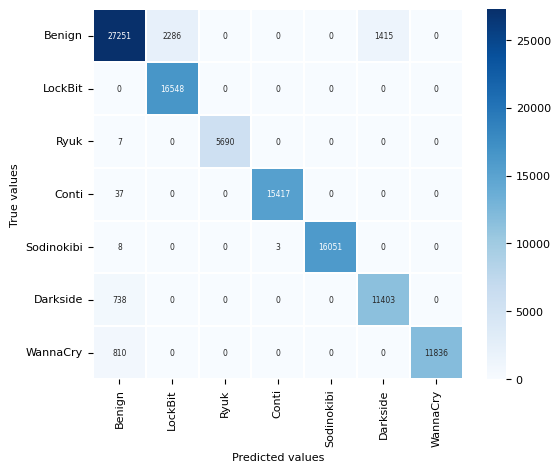

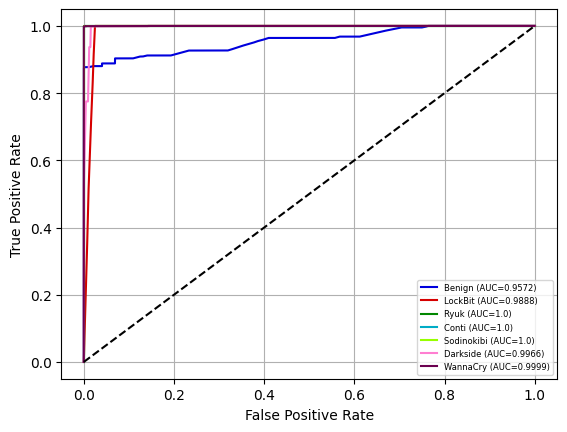

Test evaluation results: recall = 0.8515616438356165 , F1 = 0.8515297225890484 , acc = 0.8515616438356165 , precision = 0.8537139607607463 auc = 0.8917857142857143


In [26]:
visualizeResults(x_test, y_test, pipeline_nsm)

# SVM Classifier

In [11]:
# General
np.random.seed(1)

pipeline_nsm = skPipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(max_iter=500, random_state=0))])

# Repeated kfold cross validation definition
rkfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=45)

# Parameters of grid
param_grid = {
                "clf__kernel": ["rbf","linear"]
              }

# #####################
# GridSearchCV
# #####################
print("------------------------------")
print("SVC results")
print("------------------------------")
search = GridSearchCV(pipeline_nsm, param_grid, cv=rkfold, scoring='f1_micro', verbose=4)
result = search.fit(x_train, y_train)

# Training with best hyperparameters
pipeline_nsm.set_params(
    clf__kernel = result.best_params_["clf__kernel"]
    )

print(f"Best result at validation set: {result.best_score_} with hyperparameters {result.best_params_}")




------------------------------
SVC results
------------------------------
Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV 1/10] END ..................clf__kernel=rbf;, score=0.588 total time= 1.4min
[CV 2/10] END ..................clf__kernel=rbf;, score=0.530 total time= 1.6min
[CV 3/10] END ..................clf__kernel=rbf;, score=0.550 total time= 1.6min
[CV 4/10] END ..................clf__kernel=rbf;, score=0.555 total time= 1.5min
[CV 5/10] END ..................clf__kernel=rbf;, score=0.563 total time= 1.5min
[CV 6/10] END ..................clf__kernel=rbf;, score=0.564 total time= 1.5min
[CV 7/10] END ..................clf__kernel=rbf;, score=0.515 total time= 1.5min
[CV 8/10] END ..................clf__kernel=rbf;, score=0.550 total time= 1.4min
[CV 9/10] END ..................clf__kernel=rbf;, score=0.583 total time= 1.5min
[CV 10/10] END .................clf__kernel=rbf;, score=0.568 total time= 1.5min
[CV 1/10] END ...............clf__kernel=linear;, score

Retraining:
Classification report
              precision    recall  f1-score   support

           0       0.41      0.48      0.44     30952
           1       1.00      1.00      1.00     16548
           2       1.00      0.20      0.33      5697
           3       0.59      0.61      0.60     15454
           4       0.51      0.29      0.37     16062
           5       0.73      0.46      0.56     12141
           6       0.35      0.63      0.45     12646

    accuracy                           0.55    109500
   macro avg       0.66      0.52      0.54    109500
weighted avg       0.60      0.55      0.55    109500



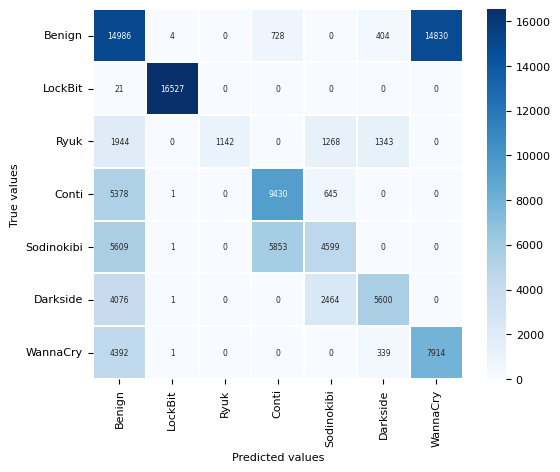

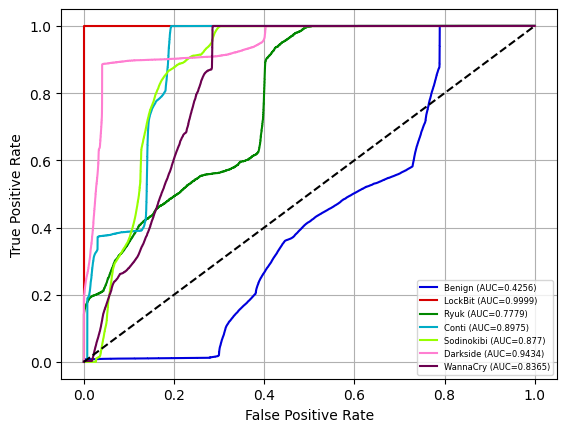

Test evaluation results: recall = 0.5497534246575343 , F1 = 0.546908284466763 , acc = 0.5497534246575343 , precision = 0.5986822638016355 auc = 0.8225428571428572


In [12]:
print("Retraining:")
pipeline_nsm2 = skPipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel="rbf", random_state=0, max_iter=400, probability=True))])

pipeline_nsm2.fit(x_train, y_train)

visualizeResults(x_test, y_test, pipeline_nsm2)

# LDA

In [13]:
# General
np.random.seed(1)

rkfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=45)
metrics = np.array([], dtype=np.int64).reshape(num_metrics,0)

for i, (train_index, val_index) in enumerate(rkfold.split(x_train, y_train)):
  pipeline_nsm = skPipeline([
     ("scaler", StandardScaler()),
     ("clf", LinearDiscriminantAnalysis())
  ])
  pipeline_nsm.fit(x_train[train_index],y_train[train_index])
  # Labels obtained
  ytrue = y_train[val_index]
  ypred = pipeline_nsm.predict(x_train[val_index])
  yproba = pipeline_nsm.predict_proba(x_train[val_index])
  # Calculate metrics
  result = calculateMetrics(ytrue, ypred, yproba, labels)
  metrics = np.hstack((metrics,result))

# Test
pipeline_nsm = skPipeline([
     ("scaler", StandardScaler()),
     ("clf", LinearDiscriminantAnalysis())
  ])
pipeline_nsm.fit(x_train,y_train)


------------------------------
Valores de métricas obtenidas:
------------------------------
precision: 0.4138926940639269
recall: 0.4138926940639269
f1-score: 0.4138926940639269
accuracy: 0.4138926940639269
error: 0.5861073059360731
specificity: 0.9023154490106545
false positive rate: 0.09768455098934548
auc: 0.7630285714285714
------------------------------
Valores de métricas obtenidas:
------------------------------
precision: 0.4137375997442893
recall: 0.4137375997442893
f1-score: 0.4137375997442893
accuracy: 0.4137375997442893
error: 0.5862624002557106
specificity: 0.9022895999573816
false positive rate: 0.09771040004261844
auc: 0.7722428571428572
------------------------------
Valores de métricas obtenidas:
------------------------------
precision: 0.41479925569926596
recall: 0.41479925569926596
f1-score: 0.41479925569926596
accuracy: 0.41479925569926596
error: 0.5852007443007341
specificity: 0.9024665426165444
false positive rate: 0.09753345738345565
auc: 0.7734857142857142
---

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', LinearDiscriminantAnalysis())])

Classification report
              precision    recall  f1-score   support

           0       0.32      0.93      0.47     30952
           1       0.89      1.00      0.94     16548
           2       0.12      0.00      0.00      5697
           3       0.00      0.00      0.00     15454
           4       0.00      0.00      0.00     16062
           5       0.00      0.00      0.00     12141
           6       0.34      0.00      0.00     12646

    accuracy                           0.41    109500
   macro avg       0.24      0.28      0.20    109500
weighted avg       0.27      0.41      0.28    109500



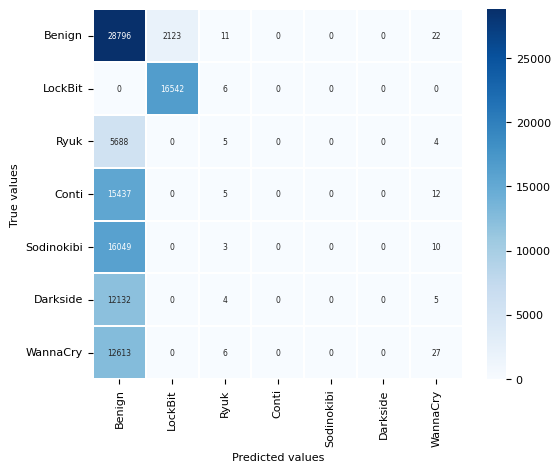

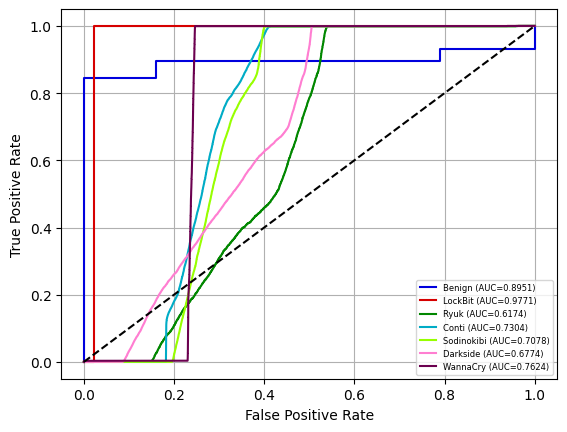

Test evaluation results: recall = 0.414337899543379 , F1 = 0.2763694342084477 , acc = 0.414337899543379 , precision = 0.26914293130566547 auc = 0.7667999999999999


In [14]:
visualizeResults(x_test, y_test, pipeline_nsm)

# Naive Bayes

In [7]:
# General
np.random.seed(1)

rkfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=45)
metrics = np.array([], dtype=np.int64).reshape(num_metrics,0)

for i, (train_index, val_index) in enumerate(rkfold.split(x_train, y_train)):
  pipeline_nsm = skPipeline([
     ("scaler", StandardScaler()),
     ("clf", GaussianNB())
  ])
  pipeline_nsm.fit(x_train[train_index],y_train[train_index])
  # Labels obtained
  ytrue = y_train[val_index]
  ypred = pipeline_nsm.predict(x_train[val_index])
  yproba = pipeline_nsm.predict_proba(x_train[val_index])
  # Calculate metrics
  result = calculateMetrics(ytrue, ypred, yproba, labels)
  metrics = np.hstack((metrics,result))

# Test
pipeline_nsm = skPipeline([
     ("scaler", StandardScaler()),
     ("clf", GaussianNB())
  ])
pipeline_nsm.fit(x_train,y_train)


------------------------------
Valores de métricas obtenidas:
------------------------------
precision: 0.111175799086758
recall: 0.111175799086758
f1-score: 0.111175799086758
accuracy: 0.111175799086758
error: 0.888824200913242
specificity: 0.8518626331811263
false positive rate: 0.14813736681887368
auc: 0.5028
------------------------------
Valores de métricas obtenidas:
------------------------------
precision: 0.1470564732474115
recall: 0.1470564732474115
f1-score: 0.1470564732474115
accuracy: 0.1470564732474115
error: 0.8529435267525884
specificity: 0.8578427455412353
false positive rate: 0.1421572544587647
auc: 0.5031142857142856
------------------------------
Valores de métricas obtenidas:
------------------------------
precision: 0.14709072021370106
recall: 0.14709072021370106
f1-score: 0.14709072021370106
accuracy: 0.14709072021370106
error: 0.8529092797862989
specificity: 0.8578484533689502
false positive rate: 0.14215154663104979
auc: 0.5039571428571428
---------------------

Pipeline(steps=[('scaler', StandardScaler()), ('clf', GaussianNB())])

Classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     30952
           1       0.00      0.00      0.00     16548
           2       0.00      0.00      0.00      5697
           3       0.00      0.00      0.00     15454
           4       0.15      1.00      0.26     16062
           5       0.00      0.00      0.00     12141
           6       0.19      0.00      0.01     12646

    accuracy                           0.15    109500
   macro avg       0.05      0.14      0.04    109500
weighted avg       0.04      0.15      0.04    109500



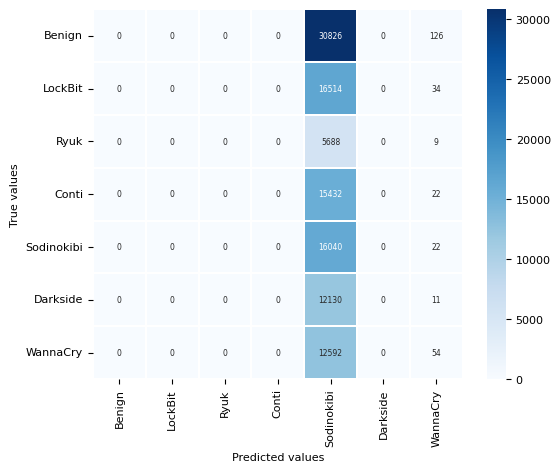

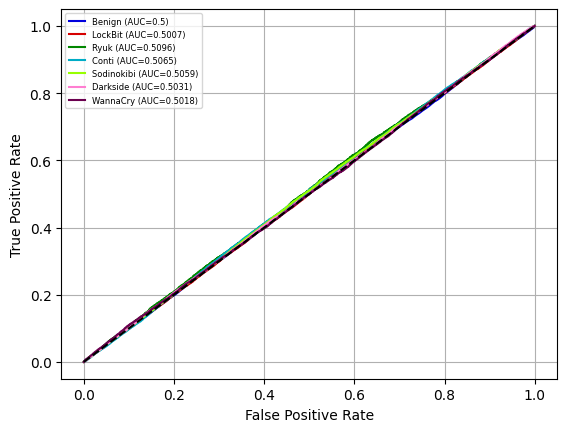

Test evaluation results: recall = 0.1469771689497717 , F1 = 0.03852497042787015 , acc = 0.1469771689497717 , precision = 0.043974722894611615 auc = 0.5039428571428571


In [8]:
visualizeResults(x_test, y_test, pipeline_nsm)